In [2]:
%pip install openpyxl
%pip install seaborn

# Суть задачи

Определить эффективность работы автокурьера, работающего в доставке "Магнита".   
Для решения этой задачи были обработаны реальные данные, полученные с 25.07.2024 по 20.09.2024.   
Данные, которые можно вытащить из приложения:   
- выручка за слот
- продожительность слота
- количество заказов в слоте
- стоимость заказа

Вместе с этим были рассчитаны и добавлены "пользовательские" данные:    
- пробег
- амортизация (условный расчет, произведенный по стоимости ежегодного ТО и недавно произведенного ремонта)
- расходы на сотовую связь (использовался "интернетный" тариф с платными звонками)

На основании всех этих данных была выработана метрика эффективности доставки, а также построена диаграмма эффективности, с помощью которой можно оценить успешность выхода на слот.  
Также была оценена реальность рекламного предолжения, что можно заработать 4000 руб. в день. 

In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

Matplotlib is building the font cache; this may take a moment.


## Датасет   
Загружаем данные из датасета magnit_delivery.xlsx, который состоит из двух листов:

Лист **"orders"** содержит информацию о стоимости одиночных* заказов:   
`order_id` - порядковый номер заказа. Заказы идут в порядке поступления    
`order_date` - дата заказа   
`order_cost` - стоимость одиночного заказа   

*в таблице не указаны мультизаказы. Информация из этого листа нужна, чтобы оценить среднюю стоимость заказа   

Лист **"slots"** содержит информацию о слотах, который были завершены с 25.07.2024 по 20.09.2024:   
`slot_date` - дата слота   
`orders_count` - количество заказов в слоте, включая мультизаказы  
`duration` - продолжительность слота в часа   
`revenue` - выручка за слот в рублях  
`distance` - суммарное расстояние, пройденное за слот  
`fuel` - расходы на бензин в рублях  
`amortiz` - амортизация автомобиля в рублях  
`tel` - расходы на сотовую связь (разговоры) в рублях 

На момент выполнения слотов в городе, где 

Гарантированная выплата составляла 190 руб./час
В рекламном предложении для моего города было сказано, что можно заработать 4000 руб./день при условии выполнения 25 заказов

In [4]:
# глобальные переменные
GARANT = 190 # гарантированная выплата в случае заранее запланированного выхода на слот и отсутствия доставок
MAX_REV = 4000  # максимальная, рекламируемая выручка за день
MAX_ORD = 25 # количество заказов, которое нужно выполнить, чтобы получить максимальную, рекламируемую выручку

In [5]:
# загружаем данные из экселя в датафреймы
# датафрейм со стоимостью одиночных заказов
df_orders = pd.read_excel('magnit_delivery.xlsx',sheet_name='orders',parse_dates=['order_date'])
# датафрейм с информацией по отработанным слотам
df_slots = pd.read_excel('magnit_delivery.xlsx',sheet_name='slots',parse_dates=['slot_date'])

### Статистика одиночных заказов

Одиночные заказы выпадают в большинстве случаев, поэтому основная выручка формируется от доставки таких заказов. Мультизаказы бывают не очень часто, и бывает так, что средняя стоимость заказа в мультизаказе ниже, чем стоимость одиночного заказа, но в случае мультизаказа меньше неоплачиваемых пробегов до магазина.

In [6]:
# выведем статистику одиночных заказов
df_orders['order_cost'].describe()

count    117.000000
mean     175.880342
std       20.068487
min      148.000000
25%      160.000000
50%      172.000000
75%      186.000000
max      232.000000
Name: order_cost, dtype: float64

Визуализируем информацию по одиночным заказам

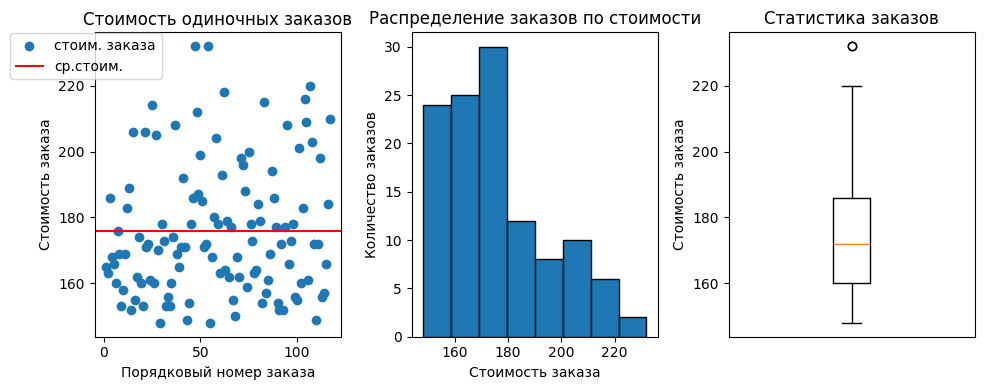

In [47]:
fig, axs = plt.subplots(1, 3, figsize=(10, 4)) # 2 rows, 2 columns

# Plot on individual axes objects
axs[0].scatter(data=df_orders, x='order_id', y='order_cost', label='стоим. заказа')
axs[0].axhline(y=df_orders['order_cost'].mean(),color='red', label='ср.стоим.')
axs[0].set_title('Стоимость одиночных заказов')
axs[0].set_xlabel('Порядковый номер заказа')
axs[0].set_ylabel('Стоимость заказа')
axs[0].legend(loc='best', bbox_to_anchor=(0.3, 1.02))

axs[1].hist(data=df_orders, x='order_cost', bins='auto',edgecolor='black')
axs[1].set_title('Распределение заказов по стоимости')
axs[1].set_xlabel('Стоимость заказа')
axs[1].set_ylabel('Количество заказов')

axs[2].boxplot(x=df_orders['order_cost'])
axs[2].set_title('Статистика заказов')
axs[2].set_ylabel('Стоимость заказа')
axs[2].set_xticks([])


plt.tight_layout()
plt.show()

Оценивая статистику по одиночным заказам, мы видим, что средняя стоимость одиночного заказа составляет 175 руб. (красная линия). Это значение может быть немного завышено за счет одного заказа, который на ящике с усами выглядит выбросом, но это реальные данные, которые удалять или выбрасывать из расчетов не следует. Тем не менее, отфильтруем данные по 90 перцентилю.

In [62]:
df_orders_99perc = df_orders[df_orders['order_cost'] < df_orders['order_cost'].quantile(0.90)]

In [63]:
df_orders_99perc['order_cost'].describe()

count    105.000000
mean     171.276190
std       15.270318
min      148.000000
25%      160.000000
50%      169.000000
75%      179.000000
max      206.000000
Name: order_cost, dtype: float64

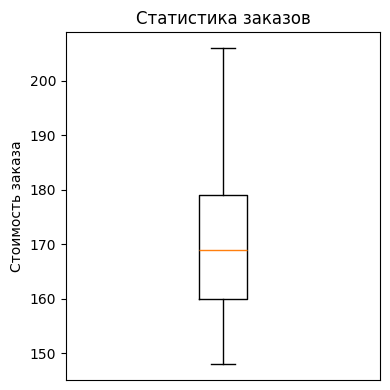

In [67]:
plt.figure(figsize=(4,4))
plt.boxplot(x=df_orders_99perc['order_cost'])
plt.title('Статистика заказов')
plt.ylabel('Стоимость заказа')
plt.xticks([])


plt.tight_layout()
plt.show()

Построив ящик с усами, видим, что выбросов больше нет, а отсеяв заказы с максимальной стоимостью получаем среднюю стоимость одиночного заказа на уровне 171 руб. Это значение будем использовать в дальнейшем.

### Расчет параметров слотов

Рассчитаем чистую прибыль для каждого слота, которая будет определяться как:   
чистая прибыль = выручка - расходы на бензин - амортизация автомобиля - расходы на сотовую связь  
profit = revenue - fuel - amortiz - tel

In [49]:
df_slots['profit'] = round((df_slots['revenue']-df_slots['fuel']-df_slots['amortiz']-df_slots['tel']),2)

Рассчитаем ряд параметров, которые характериризуют различные аспекты доставки в относительных единицах:   
1. средняя стоимость заказа на слот: выручка / количество заказов за слот
2. средняя выручка в час: выручка / продложительность слота

In [50]:
# средняя выручка на заказ  
df_slots['rev_ord'] = round(df_slots['revenue'] / df_slots['orders_count'],2)
# средняя выручка в час 
df_slots['rev_dur'] = round(df_slots['revenue'] / df_slots['duration'],2)

Рассчитаем те же самы показатели, но для чистой прибыли

In [51]:
# средняя чистая прибыль на заказ
df_slots['prof_ord'] = round(df_slots['profit'] / df_slots['orders_count'],2)
# средняя чистая прибыль в час 
df_slots['prof_dur'] = round(df_slots['profit'] / df_slots['duration'],2)

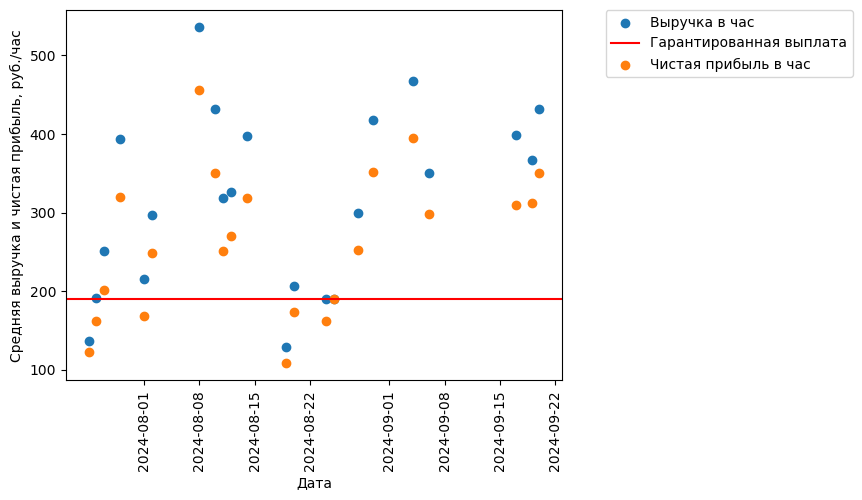

In [58]:
# диаграмма выручки и чистой прибыли в час
plt.scatter(data=df_slots, x='slot_date', y='rev_dur',label='Выручка в час')
plt.axhline(y=GARANT,color='red',label='Гарантированная выплата')
plt.scatter(data=df_slots, x='slot_date', y='prof_dur',label='Чистая прибыль в час')
plt.xlabel('Дата')
plt.ylabel('Выручка и чистая прибыль в час, руб./час')
plt.xticks(rotation=90)
plt.legend(bbox_to_anchor=(1.6, 1.02))
plt.show()

Очевидно, что различие между чистой прибылью и выручкой будет иметь место, за исключением того случая, когда был простой и курьер получил гарантированную выплату. Красная линия показывает значение гарантированной выплаты, то есть, по сути, выручку (она же чистая прибыль) в случае простоя. Можно сказать, что значения выручки ниже этой черты указывают на неудачный выход, когда стоять на месте выгоднее, чем развозить заказы.

Построим диаграмму для выручки и чистой прибыли на один заказ. Также укажем размер средней стоимости одиночного заказа, рассчитанный ранее.

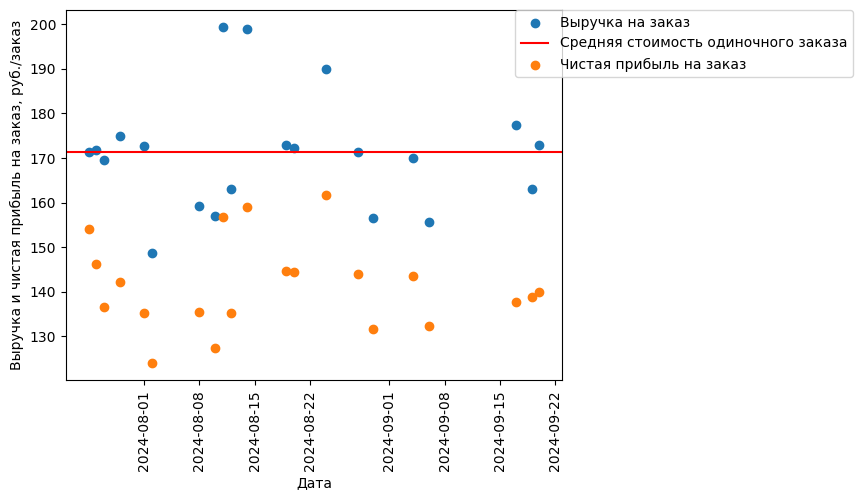

In [68]:
# диаграмма выручки и чистой прибыли на заказ
plt.scatter(data=df_slots, x='slot_date', y='rev_ord',label='Выручка на заказ')
plt.axhline(y=df_orders_99perc['order_cost'].mean(),color='red',label='Средняя стоимость одиночного заказа')
plt.scatter(data=df_slots, x='slot_date', y='prof_ord',label='Чистая прибыль на заказ')
plt.xlabel('Дата')
plt.ylabel('Выручка и чистая прибыль на заказ, руб./заказ')
plt.xticks(rotation=90)
plt.legend(bbox_to_anchor=(1.6, 1.02))
plt.show()

В контексте этой диаграммы нет смысла смотреть чистую выручку относительно средней стоимости одиночного заказа (которая, по сути, является средней выручкой на заказ). Куда интереснее посмотреть на расположение чистой выручки на заказ относительно средней стоимости одиночного заказа. В ряде случаев, выручка на заказ ниже средней стоимости одиночного заказа. Забегая вперед, отмечу, что средняя стоимость заказа для получения выручки 4000 руб./день, должна составлять 160 руб./заказ. Но даже при этом значении, будут слоты, когда средняя стоимость заказа ниже этой величины. А это означает, что такие выходы принесли мало прибыли.

### Метрика эффективности доставки для курьера

Добавим еще один параметр в наш датафрейм - отношение чистой прибыли к выручке.   
Очевидно, что чем выше это отношение, тем меньше накладных расходов понес курьер, осуществляя доставку.

In [69]:
df_slots['prof_rev'] = round(df_slots['profit'] / df_slots['revenue'],2)

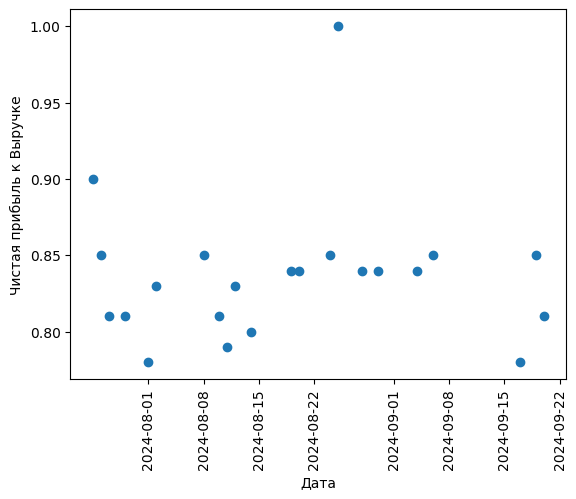

In [73]:
# диаграмма отношения чистой прибыли к выручке
plt.scatter(data=df_slots, x='slot_date', y='prof_rev',label='Чистая прибыль к Выручке')
plt.xlabel('Дата')
plt.ylabel('Чистая прибыль к Выручке')
plt.xticks(rotation=90)

plt.show()

А разве может эта метрика быть равной единице?  Может! Это тот случай, когда нет заказов и курьер получает гарантированную выплату 190 руб./час.   
В остальном, чем больше эта метрика, тем удачнее вышел слот.

### Диаграмма эффективности доставки

Объединив две метрики чистая прибыль в час и чистая прибыль к выручке на одной диграмме, можно визуализировать эффективность доставки для курьера. Также нанесем величину гарантированной выплаты, как своего рода "водораздел", отмечающий линию, ниже которой стоять на месте выгоднее, чем развозить заказы.

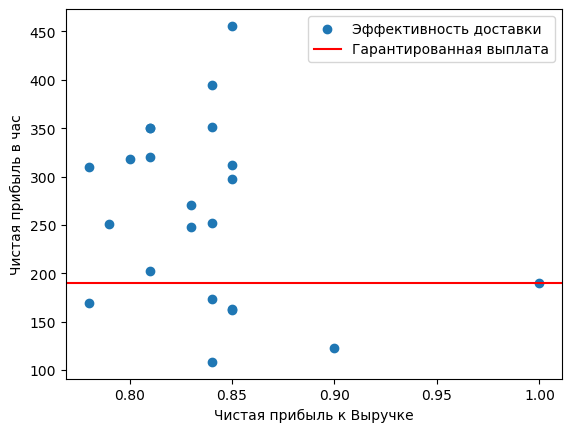

In [77]:
# диаграмма эффективности доставки
plt.scatter(data=df_slots, x='prof_rev', y='prof_dur',label='Эффективность доставки')
plt.axhline(y=GARANT,color='red',label='Гарантированная выплата')
plt.xlabel('Чистая прибыль к Выручке')
plt.ylabel('Чистая прибыль в час')
plt.legend()

plt.show()

"Водораздел" в 190 руб./час (который, по сути, является чистой прибылью в час при условии отсутствия заказов) показывает, что если значения чистой прибыли находятся ниже, то независимо от соотношения чистой прибыли к выручке, стоять на гарантированной выплате выгоднее.  
Выше "водораздела" наиболее эффективный слот будет отражаться точкой, которая стремится в правый верхний угол. То есть, при минимуме накладных расходов получается максимальная чистая прибыль в час.   
Очевидно, что рост прибыли будет зависеть от пробега, а увеличение пробега  будет снижать соотношение Ч.п./В за счет расходов на топливо.

Наконец прикинем среднее значениме метрики эффективности:

In [90]:
print(f'Среднее значениме метрики эффективности {df_slots['prof_rev'].mean().round(2)}')

Среднее значениме метрики эффективности 0.84


Среднее значение отношения чистой прибыли к выручке составляет 0,84. Очевидно, что увеличением количества данных, это значение скорректируется либо в одну, либо в другую сторону. И вполне вероятно, что будет зависеть от сезона. Но уже на этом этапе его можно применять для оценки чистой прибыли, не прибегая к громоздким расчетам.

### Сравнение с "бенчмарком"

На момент получения этих данных рекламное предложение для моего города звучало примерно так:  
>4000 руб. в день!*   
>*при условии выполнения 25 заказов

Осталось оценить за какое время можно выполнить 25 заказов.   
Для этого нужно понимать сколько заказов можно сделать за слот, а слоты имеют различную продолжительность. Минимальный - 4 часа, максимальный - 12 часов.  

Определим среднюю стоимость заказа по "бенчмарку"

In [88]:
# средняя стоимость заказа по "бенчмарку"
AVG_COST = MAX_REV / MAX_ORD
print(f'Средняя стоимость заказа по "бенчмарку" {AVG_COST} руб.')

Средняя стоимость заказа по "бенчмарку" 160.0 руб.


Рассчитаем количество заказов за час, исходя из возможных продолжительностей слота

In [83]:
# количество заказов за час
slot_list = list(range(4,13,2))
AVG_ORD_list=[]
d={}
for item in slot_list:
    AVG_ORD_list.append(round(MAX_ORD / item,1))
res=pd.DataFrame({
    'slot_duration':slot_list,
    'avg_orders':AVG_ORD_list})
res

,slot_duration,avg_orders
0,4,6.2
1,6,4.2
2,8,3.1
3,10,2.5
4,12,2.1


Необходимо отметить, что 4 заказа в час и более, сделать очень сложно или почти невозможно по следующим причинам:   
1. можно долго ждать заказ в магазине
2. можно долго искать клиента
3. можно долго ждать пока клиент отзовется
4. можно долго ехать до магазина или до клиента (да, есть таймер, но и есть пробки...)
5. никто не обещал, что заказы будут сыпаться один за другим

Мое мнение, автокурьеру сложно делать более 4 заказов в час.

Теперь рассчитаем сколько заказов за час было выполнено в рамках реально отработанных слотов:

In [78]:
df_slots['ord_dur'] = round(df_slots['orders_count'] / df_slots['duration'],2)

Выведем статистику по заказам

In [79]:
df_slots['ord_dur'].describe()

count    22.000000
mean      1.817273
std       0.807885
min       0.000000
25%       1.212500
50%       2.000000
75%       2.250000
max       3.370000
Name: ord_dur, dtype: float64

Видим, что в среднем выходит порядка 2 заказов в час. Бывают дни, когда заказов меньше одного в час, бывает больше трех, но в среднем для того, чтобы получать 4000 руб. в день, нужно выходить на 12-ти часовой слот, и надеяться, что будут давать не меньше 2-х заказов в час.   
И не нужно забывать, что это ВЫРУЧКА, а чистая прибыль будет меньше. Меньше в 0,84 раза: 

In [86]:
print(f'Расчетная чистая прибыль, полученная из рекламируемой выручки: {MAX_REV*0.84}')

Расчетная чистая прибыль, полученная из рекламируемой выручки: 3360.0


### Заключение   
Предложенный подход позволяет оценить эффективность доставки автокурьером, работающим в "Магните". Данный подход можно адаптировать для других типов курьеров, но для этого нужно оценить накладные расходы в каждом конкретном случае.   
Несмотря на это приведенный выше код можно без труда адаптировать для персональных расчетов.   
Можно расширить задачу, сравнив работу курьера с другой профессией, не по размеру чистой прибыли, а по совокупности факторов. Курьер, будучи самозанятым не имеет ряда социальных гарантий в виде оплачиваемого больничного, пенсии и т.п. Чтобы  самостоятельно обеспечить себе хотя бы лечение, на него нужно откладывать, и следовательно, это тоже повлияет на конечный уровень дохода.